In [1]:
import os
os.chdir("UQ_toolbox")

In [3]:
%load_ext autoreload
%autoreload 2

import uncertainty_toolbox as uct
import pickle
import uncertainty_toolbox.viz as uviz

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import numpy as np

df = pickle.load(open( '../netherlands_UQ.p', "rb" ))
y = df["valCases"].dropna().values[-56:]
predictions = df.iloc[:, 2:].mean(axis=1).dropna()[-len(y):].values
predictions_std = df.iloc[:, 3:].std(axis=1).dropna()[-len(y):].values 
bounds = [np.min(predictions) / 3.5, np.max(predictions) * 1.5]
x = np.linspace(bounds[0], bounds[1], len(y))

# Compute all uncertainty metrics
metrics = uct.metrics.get_all_metrics(predictions, predictions_std, y)

 (1/n) Calculating accuracy metrics
 (2/n) Calculating average calibration metrics


 10%|█         | 1/10 [00:00<00:01,  7.62it/s]

 (3/n) Calculating adversarial group calibration metrics
  [1/2] for mean absolute calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


  0%|          | 0/10 [00:00<?, ?it/s]

  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:01<00:00,  5.34it/s]

 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           1463.153
  RMSE          1747.521
  MDAE          1415.351
  MARPD         25.398
  R2            0.452
  Correlation   0.866
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.101
  Mean-absolute Calibration Error       0.083
  Miscalibration Area                   0.083
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.216
     Group Size: 0.56 -- Calibration Error: 0.117
     Group Size: 1.00 -- Calibration Error: 0.083
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.281
     Group Size: 0.56 -- Calibration Error: 0.142
     Group Size: 1.00 -- Calibration Error: 0.101
======

In [33]:
bounds = [np.min(predictions) / 2, np.max(predictions) * 1.5]
x = np.linspace(bounds[0], bounds[1], len(y))

# Make xy plot
uviz.plot_xy(predictions, predictions_std / 2, y, x, n_subset=int(len(y) / 2.5), ylims=bounds)
uviz.plotly_intervals(predictions, predictions_std / 2, y, n_subset=int(len(y) / 2.5), ylims=[1500, 12000])
uviz.plotly_calibration(predictions, predictions_std, y)
uviz.plotly_intervals_ordered(predictions, predictions_std, y, n_subset=int(len(y) / 1.5), ylims=[0, 20000])


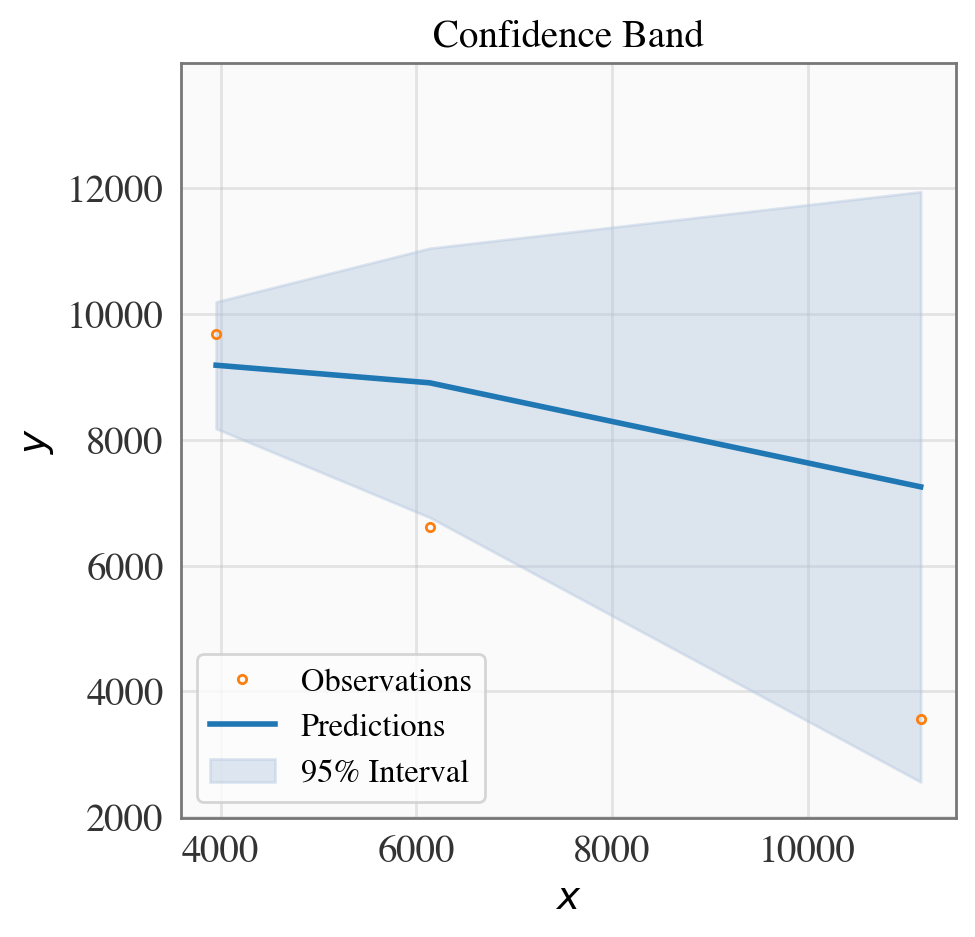

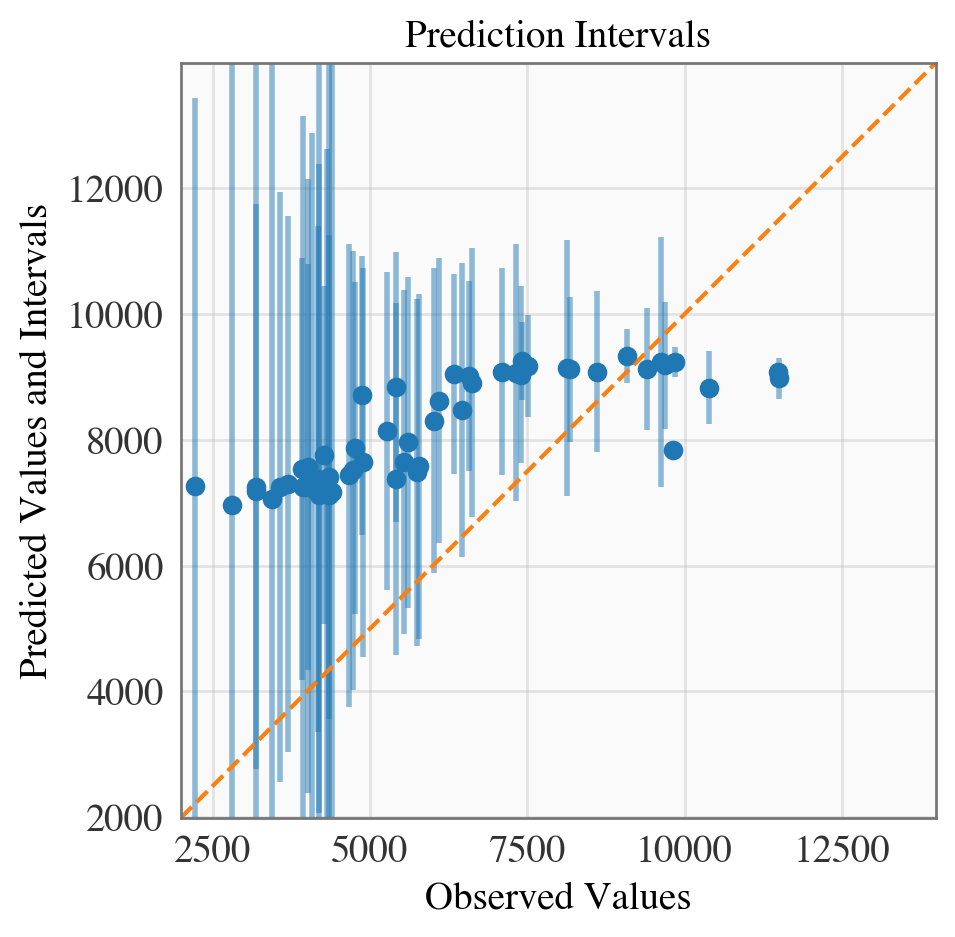

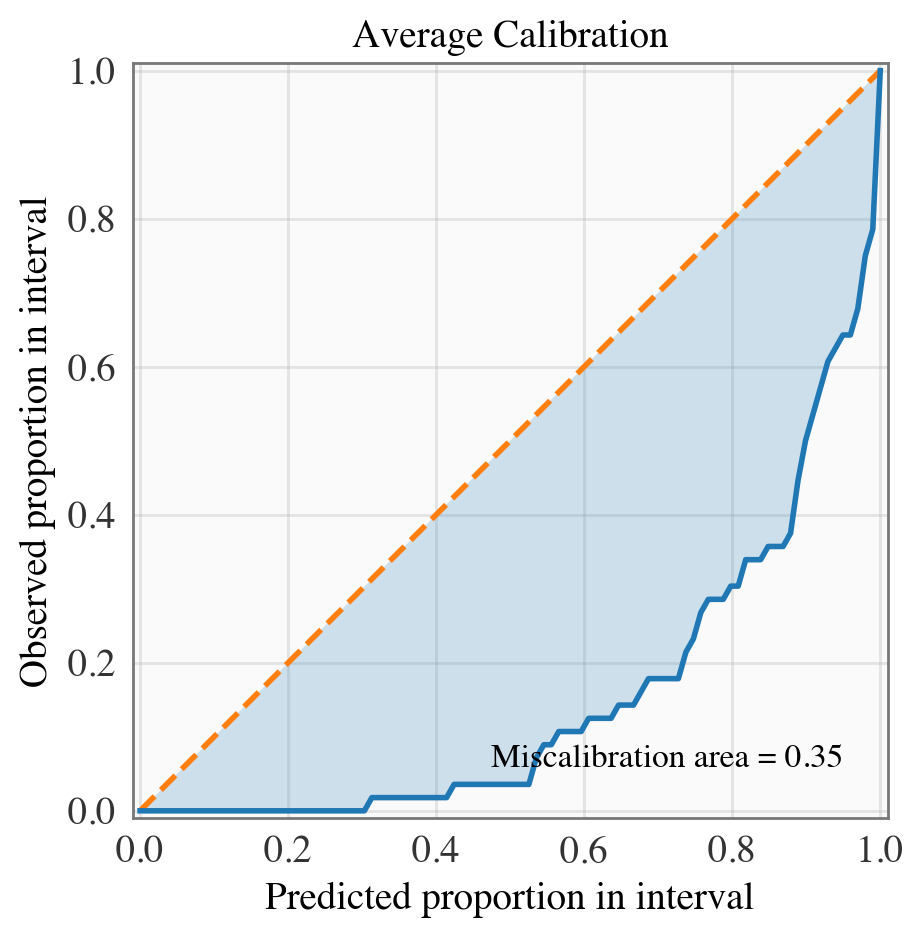

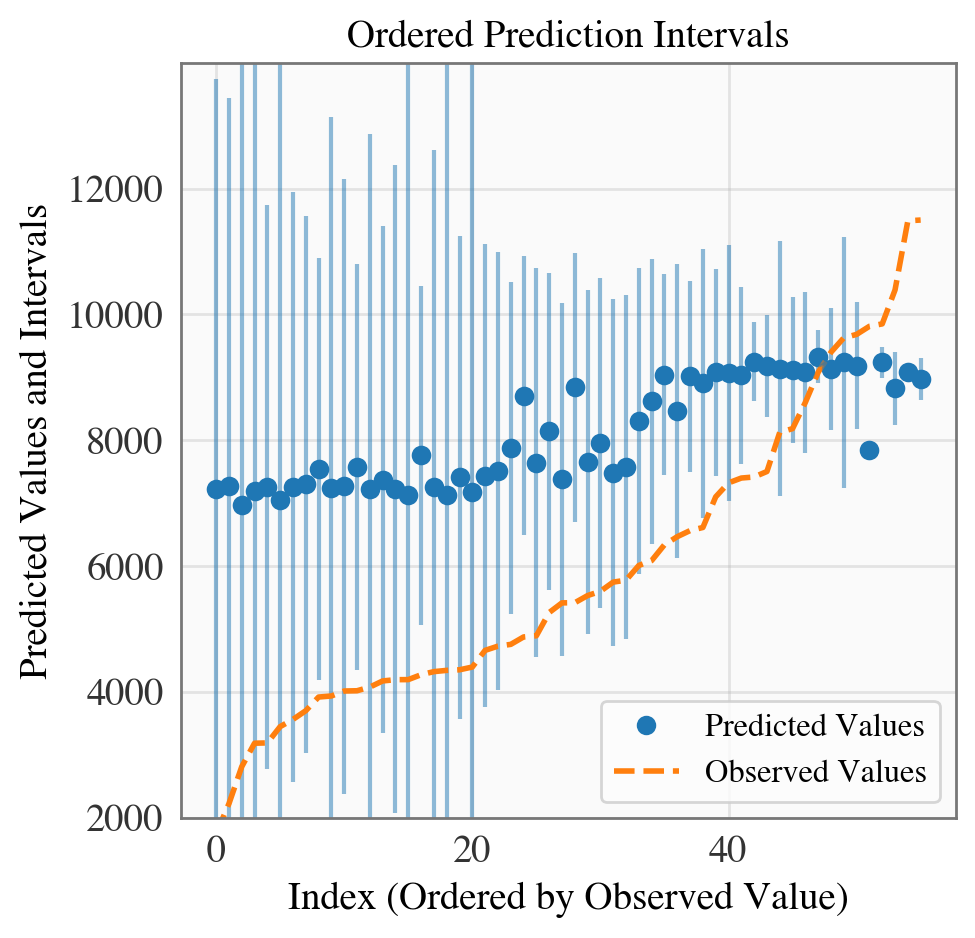

MACE: 0.34321428571428575, RMSCE: 0.3784767481228522, MA: 0.3466810966810967


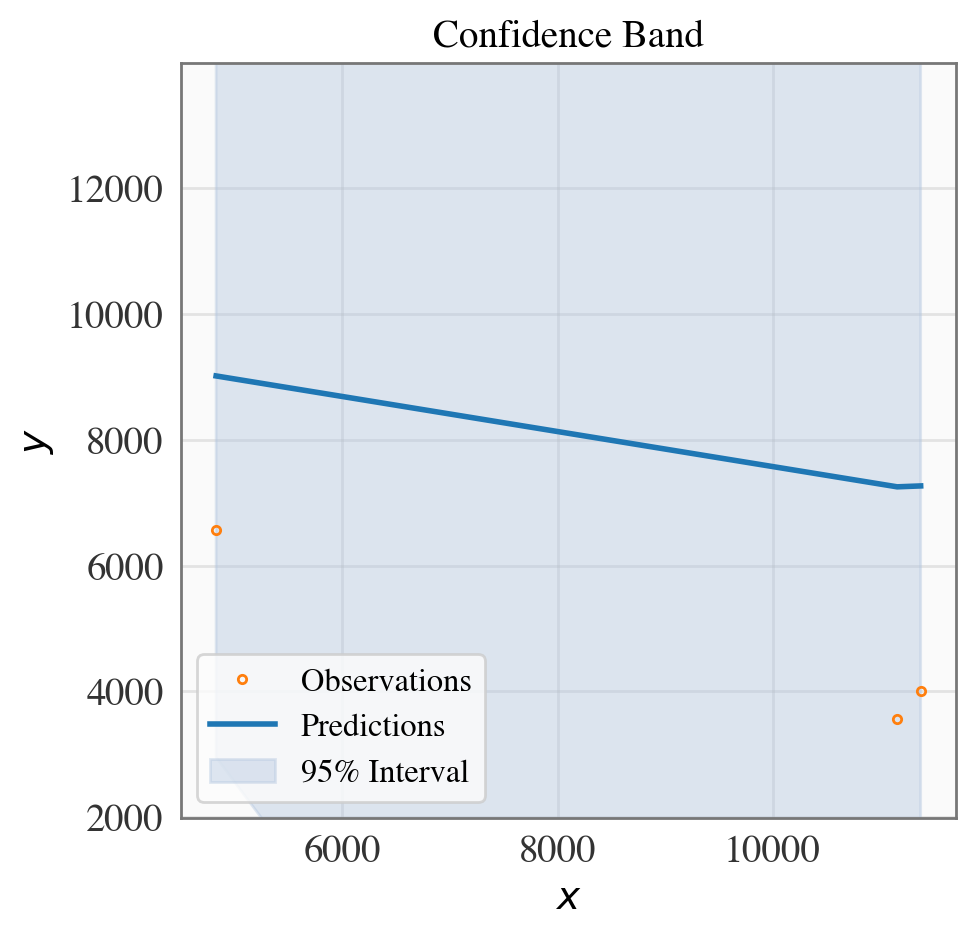

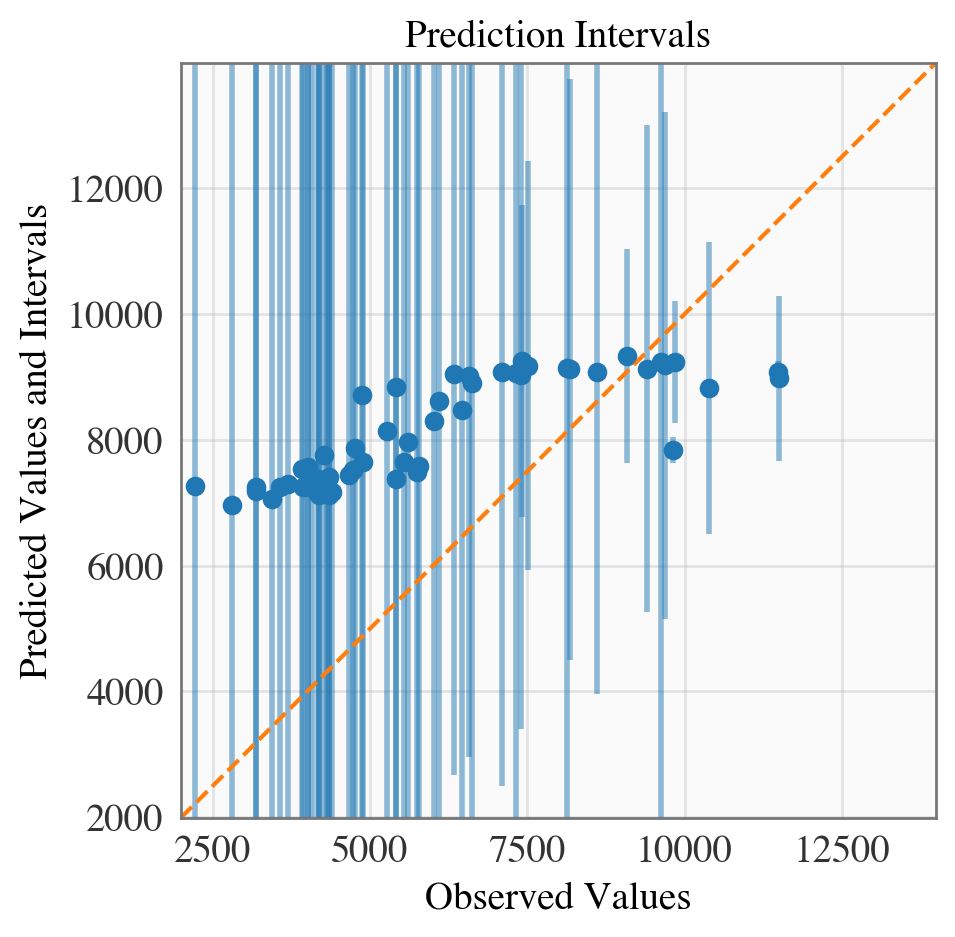

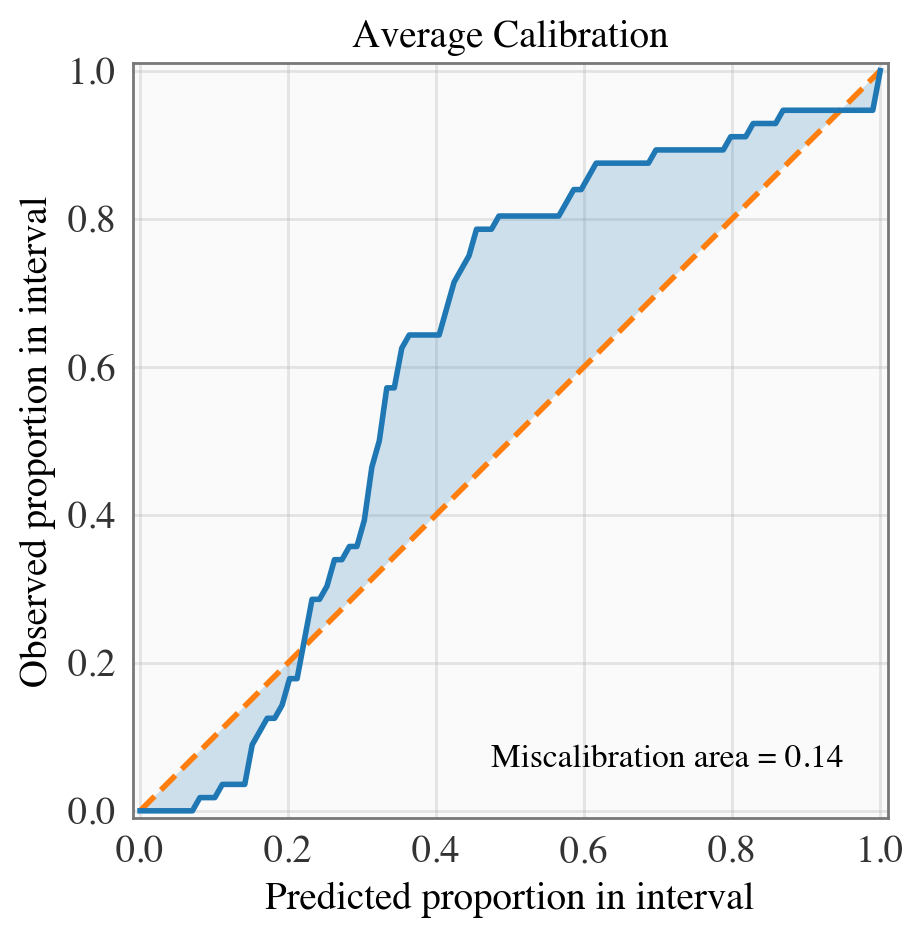

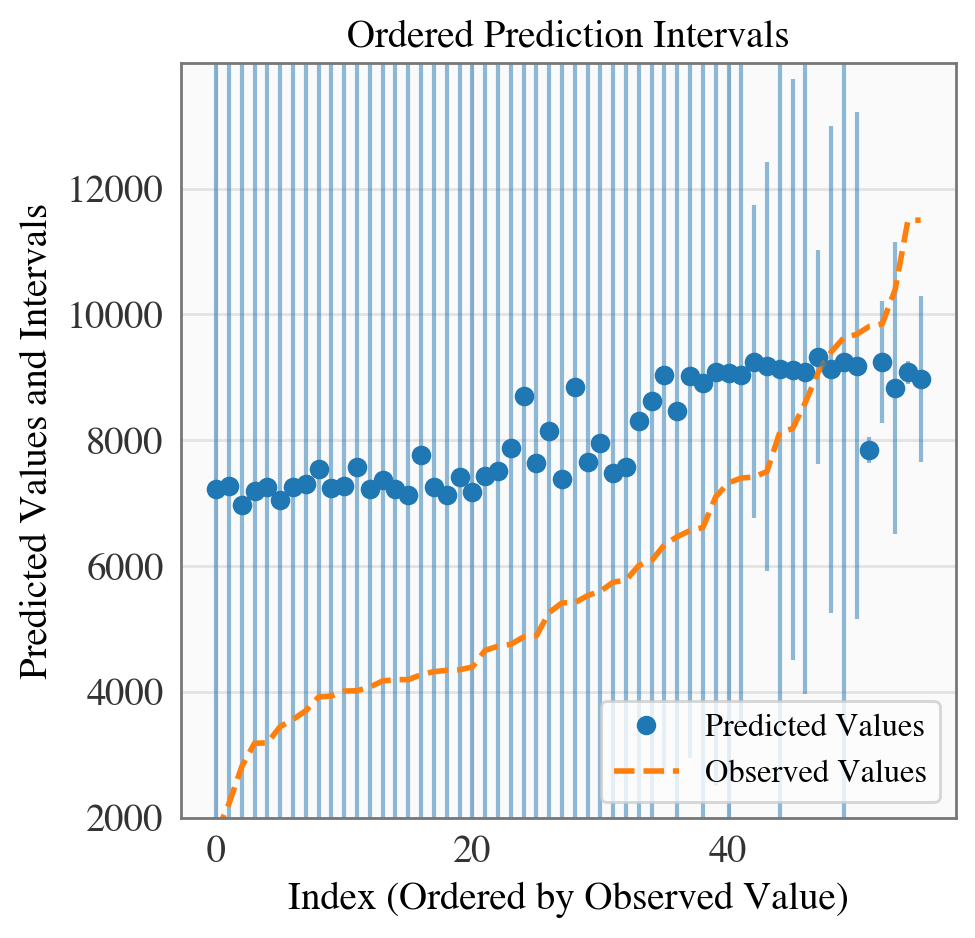

MACE: 0.1409577922077922, RMSCE: 0.17339091374884374, MA: 0.14228269816036554


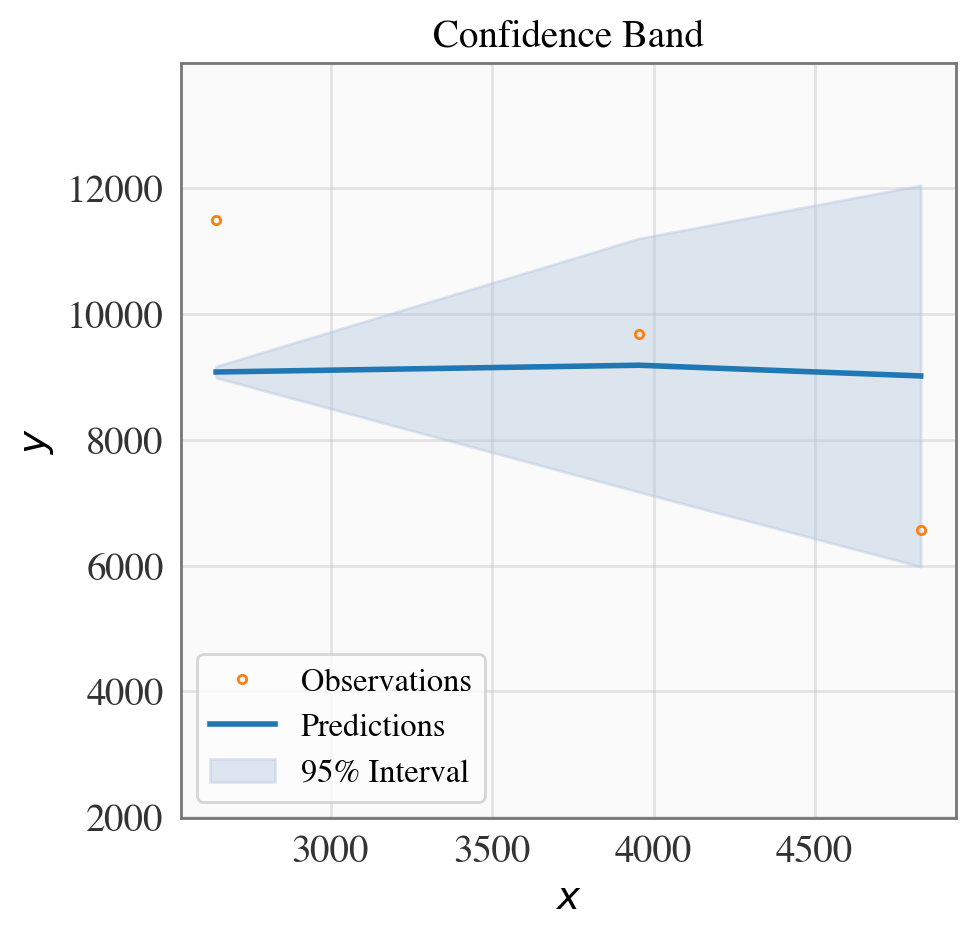

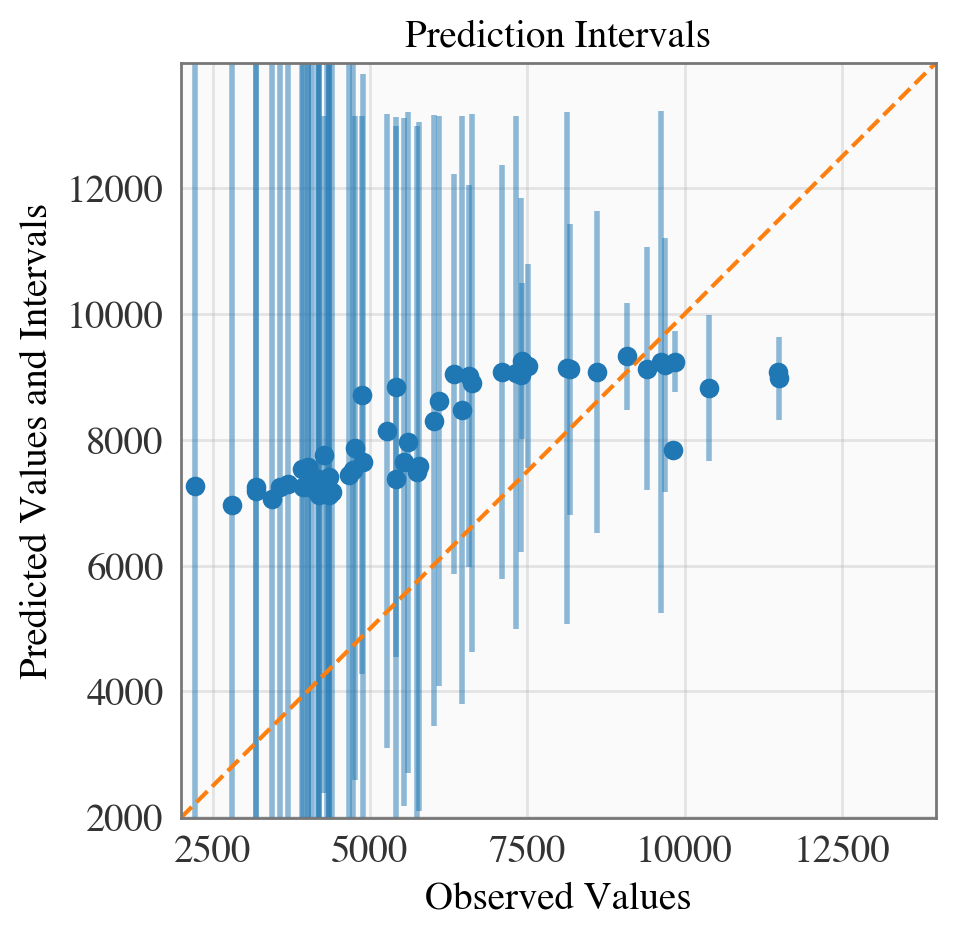

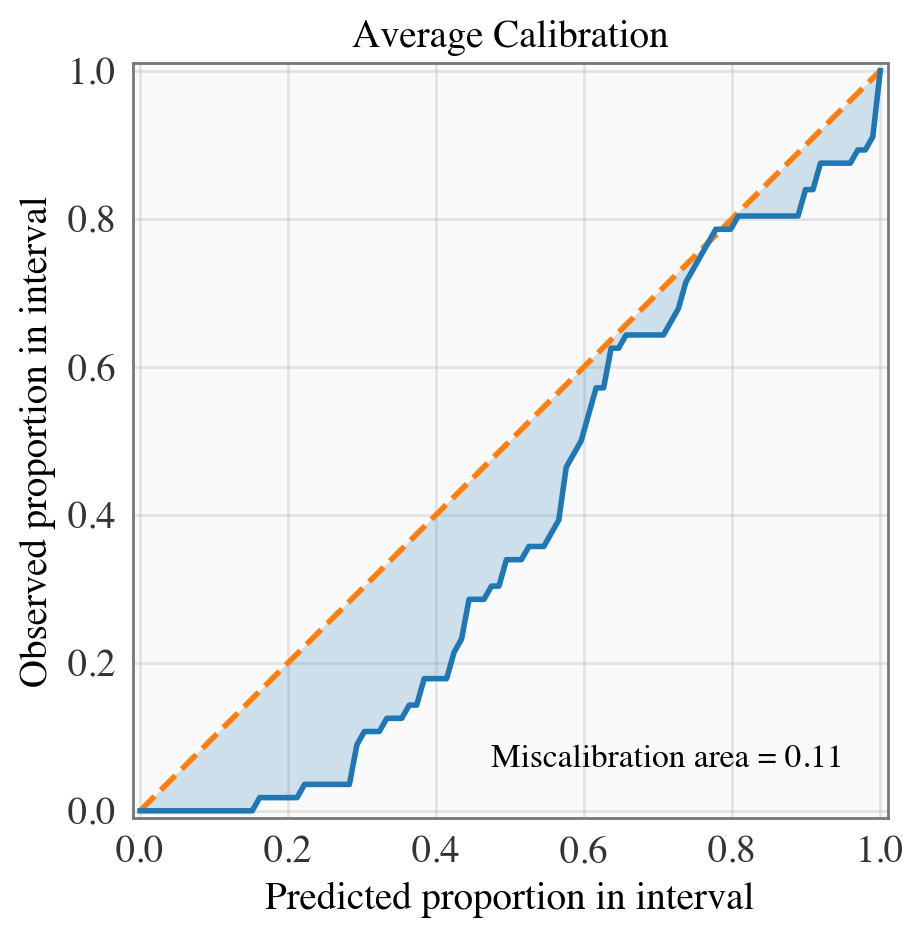

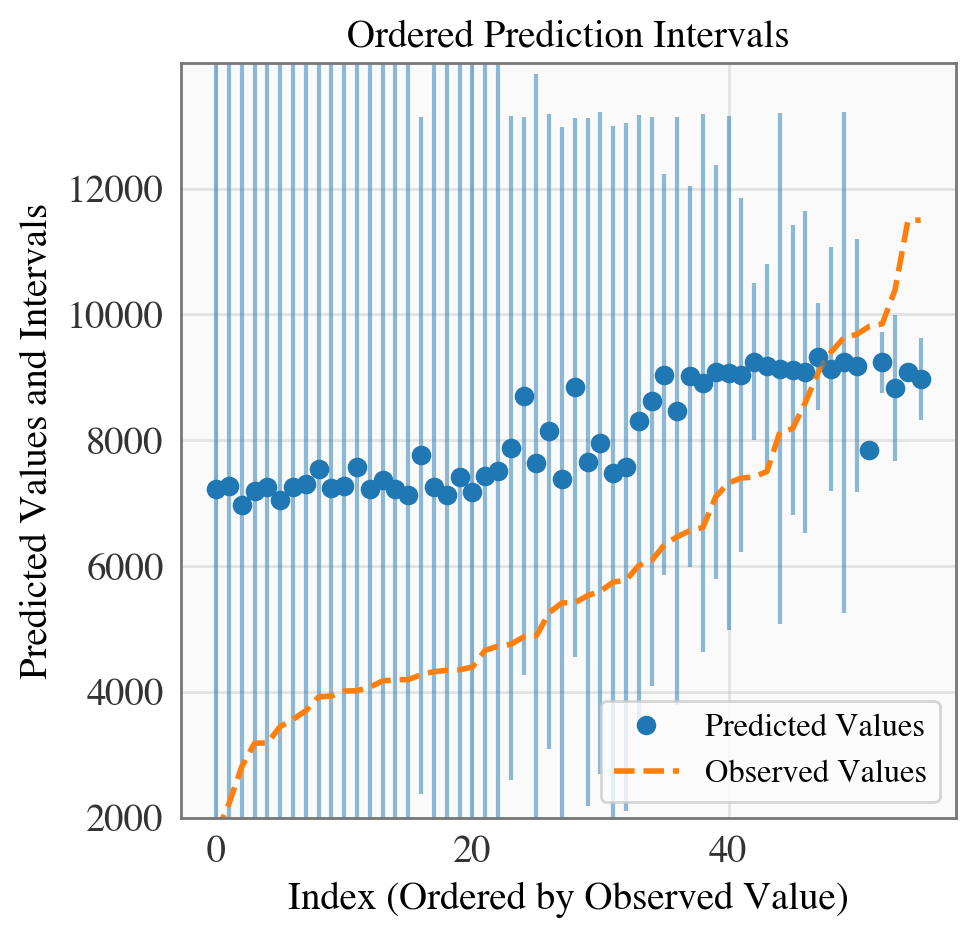

MACE: 0.11230519480519482, RMSCE: 0.13597305145069588, MA: 0.11342063252362261


In [108]:
"""
Examples of code for visualizations.
"""
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc

import uncertainty_toolbox.data as udata
import uncertainty_toolbox.metrics as umetrics
import uncertainty_toolbox.viz as uviz

import neatplot

neatplot.set_style()
neatplot.update_rc("text.usetex", False)  # Set to True for system latex

                                      
# Set random seed
np.random.seed(11)

# Generate synthetic predictive uncertainty results
n_obs = len(y)
f, std, y, x = predictions, predictions_std, y, x 

# Save figure (set to True to save)
savefig = False


def save_figure(name_str, file_type="png"):
    """Save figure, or do nothing if savefig is False."""
    if savefig:
        neatplot.save_figure(name_str, file_type)


def update_rc_params():
    """Update matplotlib rc params."""
    plt.rcParams.update({"font.size": 14})
    plt.rcParams.update({"xtick.labelsize": 14})
    plt.rcParams.update({"ytick.labelsize": 14})
    plt.rcParams.update({"figure.figsize": (5, 5)})


def make_plots(pred_mean, pred_std, idx1, idx2):
    """Make set of plots."""

    update_rc_params()
    ylims = bounds
    n_subset = len(y)

    # Make xy plot
    uviz.plot_xy(pred_mean, pred_std, y, x, n_subset=3, ylims=ylims)
    save_figure(f"xy_{idx1}_{idx2}")
    plt.show()

    # Make intervals plot
    uviz.plot_intervals(pred_mean, pred_std, y, n_subset=n_subset, ylims=ylims)
    save_figure(f"intervals_{idx1}_{idx2}")
    plt.show()

    # Make calibration plot
    uviz.plot_calibration(pred_mean, pred_std, y)
    save_figure(f"calibration_{idx1}_{idx2}")
    plt.show()

    # Make ordered intervals plot
    uviz.plot_intervals_ordered(pred_mean, pred_std, y, n_subset=n_subset, ylims=ylims)
    save_figure(f"intervals_ordered_{idx1}_{idx2}")
    plt.show()


# List of predictive means and standard deviations
pred_mean_list = [f]

pred_std_list = [
    std * 0.5,  # overconfident
    std * 2.0,  # underconfident
    std,  # correct
]

# Loop through, make plots, and compute metrics
for i, pred_mean in enumerate(pred_mean_list):
    for j, pred_std in enumerate(pred_std_list):
        mace = umetrics.mean_absolute_calibration_error(pred_mean, pred_std, y)
        rmsce = umetrics.root_mean_squared_calibration_error(pred_mean, pred_std, y)
        ma = umetrics.miscalibration_area(pred_mean, pred_std, y)

        make_plots(pred_mean, pred_std, i, j)

        print(f"MACE: {mace}, RMSCE: {rmsce}, MA: {ma}")